# SDSS Whole Dataset

In [1]:
import numpy as np
import pandas as pd
import pickle
import ephem
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pandas import MultiIndex
from IPython.display import display
from IPython.core.display import HTML
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')
%run scripts/performance_measures.py
HTML(open("styles/stylesheet.css", "r").read())

## 1. Train a Random Forest

In [2]:
sdss = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip")

In [21]:
def reddening_correction(sdss):
    sdss['E_BV'] = sdss['extinction_r'] / 2.751

    E_region_2 = np.logical_and(sdss['E_BV'] >= 0.04, sdss['E_BV'] < 0.08)
    E_region_3 = sdss['E_BV'] >= 0.08

    sdss['Ecorr_BV'] = sdss['E_BV']
    sdss['Ecorr_BV'].loc[E_region_2] = sdss['E_BV'][E_region_2] + 0.5 * (sdss['E_BV'][E_region_2] - 0.04)
    sdss['Ecorr_BV'].loc[E_region_3] = sdss['E_BV'][E_region_3] + 0.02

    sdss['A_u_w14'] = sdss['Ecorr_BV'] * 4.305
    sdss['A_g_w14'] = sdss['Ecorr_BV'] * 3.288
    sdss['A_r_w14'] = sdss['Ecorr_BV'] * 2.261
    sdss['A_i_w14'] = sdss['Ecorr_BV'] * 1.714
    sdss['A_z_w14'] = sdss['Ecorr_BV'] * 1.263

    sdss['psfMag_u_w14'] = sdss['psfMag_u'] - sdss['A_u_w14']
    sdss['psfMag_g_w14'] = sdss['psfMag_g'] - sdss['A_g_w14']
    sdss['psfMag_r_w14'] = sdss['psfMag_r'] - sdss['A_r_w14']
    sdss['psfMag_i_w14'] = sdss['psfMag_i'] - sdss['A_i_w14']
    sdss['psfMag_z_w14'] = sdss['psfMag_z'] - sdss['A_z_w14']

    sdss['petroMag_u_w14'] = sdss['petroMag_u'] - sdss['A_u_w14']
    sdss['petroMag_g_w14'] = sdss['petroMag_g'] - sdss['A_g_w14']
    sdss['petroMag_r_w14'] = sdss['petroMag_r'] - sdss['A_r_w14']
    sdss['petroMag_i_w14'] = sdss['petroMag_i'] - sdss['A_i_w14']
    sdss['petroMag_z_w14'] = sdss['petroMag_z'] - sdss['A_z_w14']

    sdss['psf_u_g_w14'] = sdss['psfMag_u_w14'] - sdss['psfMag_g_w14']
    sdss['psf_g_r_w14'] = sdss['psfMag_g_w14'] - sdss['psfMag_r_w14']
    sdss['psf_r_i_w14'] = sdss['psfMag_r_w14'] - sdss['psfMag_i_w14']
    sdss['psf_i_z_w14'] = sdss['psfMag_i_w14'] - sdss['psfMag_z_w14']

    sdss['petro_u_g_w14'] = sdss['petroMag_u_w14'] - sdss['petroMag_g_w14']
    sdss['petro_g_r_w14'] = sdss['petroMag_g_w14'] - sdss['petroMag_r_w14']
    sdss['petro_r_i_w14'] = sdss['petroMag_r_w14'] - sdss['petroMag_i_w14']
    sdss['petro_i_z_w14'] = sdss['petroMag_i_w14'] - sdss['petroMag_z_w14']

In [11]:
def train_random_forest(sdss, feature_names, drop_coords=True):
    """ Train a random forest given a set of features. """
    
    # split the data into a training set
    X_train, X_test, y_train, y_test = train_test_split(sdss[feature_names], sdss['class'],
        train_size=0.95, test_size=0.05, random_state=4)

    coords_train = X_train[['ra', 'dec']]
    coords_test = X_test[['ra', 'dec']]
    
    # remove coordinates as features
    if drop_coords:
        X_train.drop(['ra', 'dec'], axis=1, inplace=True)
        X_test.drop(['ra', 'dec'], axis=1, inplace=True)

    # train and test random forest
    clf_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, class_weight='auto', random_state=5)
    clf_forest.fit(X_train, y_train)
    y_pred_test = clf_forest.predict(X_test)
    confusion_test = metrics.confusion_matrix(y_test, y_pred_test)
    balanced_accuray_forest = balanced_accuracy_expected(confusion_test)

    # put confusion matrix in a DataFrame
    classes = ['Galaxies', 'Quasars', 'Stars']
    pred_index = MultiIndex.from_tuples(list(zip(['Predicted'] * 3, classes)))
    act_index = MultiIndex.from_tuples(list(zip(['Actual'] * 3, classes)))
    confusion_features_df = DataFrame(confusion_test, columns=pred_index, index=act_index)

    # display results
    print('Here\'s the confusion matrix:')
    display(confusion_features_df)
    print('The balanced accuracy rate is {:.2%}.'.format(balanced_accuray_forest))
        
    return clf_forest

In [14]:
colour_features = ['ra', 'dec',
                   'psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
                   'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
                   'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14', 'petro_i_z_w14']

clf_forest = train_random_forest(sdss, colour_features)

with open('results/sdss_whole_dataset/forest.pickle', 'wb') as f:
        pickle.dump(clf_forest, f, pickle.HIGHEST_PROTOCOL)

Here's the confusion matrix:


Predicted                
                  Galaxies  Quasars  Stars
Actual Galaxies      84339      665    331
       Quasars         922    16454   1602
       Stars           707     1978  33053

The balanced accuracy rate is 92.67%.


## 2. Predicting Unknowns

In [81]:
features = ['psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
            'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
            'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14', 'petro_i_z_w14']
result_cols = ['ra', 'dec', 'type', 'clean', 'probPSF', 'prediction']
sdss_dtype = {'type': int, 'clean': int}
sdss_cols = ['objID', 'ra', 'dec', 'specobjid', 'class', 'subclass', 'redshift', 'redshiftErr', 'zWarning',
             'type', 'clean', 'flags', 'probPSF', 'psfMag_u', 'psfMagErr_u', 'psfMag_g', 'psfMagErr_g',
             'psfMag_r', 'psfMagErr_r', 'psfMag_i', 'psfMagErr_i', 'psfMag_z', 'psfMagErr_z', 'petroMag_u',
             'petroMagErr_u', 'petroMag_g', 'petroMagErr_g', 'petroMag_r', 'petroMagErr_r', 'petroMag_i',
             'petroMagErr_i', 'petroMag_z', 'petroMagErr_z', 'extinction_u', 'extinction_g', 'extinction_r',
             'extinction_i', 'extinction_z', 'petroRad_r', 'petroRadErr_r']

for i in np.arange(0, 100):
    sdss_file = r'F:\SDSS\ANUdata{0:02d}.csv'.format(i)
    
    if i == 0:
        sdss_iterator = pd.io.api.read_csv(sdss_file, chunksize=50000, dtype=sdss_dtype)
    else:
        sdss_iterator = pd.io.api.read_csv(sdss_file, chunksize=50000, dtype=sdss_dtype, header=None, names=sdss_cols)
    
    results = pd.DataFrame(columns=result_cols, dtype=float)
    results['type'] = results['type'].astype(int)
    results['clean'] = results['clean'].astype(int)
    
    for chunk in sdss_iterator:
        reddening_correction(chunk)
        chunk['prediction'] = clf_forest.predict(chunk[features])
        results = pd.concat([results, chunk[result_cols]], ignore_index=True)
        
    result_file = r'F:\SDSS\predictions\predict{0:02d}.csv'.format(i)
    results.to_csv(result_file, index=False)
    del results

## 3. Plotting Predictions

In [7]:
def plot_hex_map(ra, dec, origin=0, title='Distribution of Objects', projection='mollweide', milky_way=True,
                C=None, reduce_C_function=np.mean, mincnt=1, gridsize=100, cmap=plt.cm.bone_r,
                vmin=None, vmax=None, bins=None):
    """ Plot density of objects on a map. """
    
    # shift ra values to range [-180, +180]
    ra = np.remainder(ra + 360 - origin, 360)
    ra[ra > 180] -= 360
    
    # reverse scale so that East is to the left
    ra = -ra
    
    # shift dec values to range [-180, +180]
    dec = np.remainder(dec + 360, 360)
    dec[dec > 180] -= 360
    
    # set tick labels to correct values
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels + 360 + origin, 360)
    
    # plot data on map
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection=projection, axisbg='white')
    hex_quasar = ax.hexbin(np.radians(ra), np.radians(dec), cmap=cmap, mincnt=mincnt,
                           vmin=vmin, vmax=vmax, bins=bins,
                           zorder=-1, C=C, reduce_C_function=reduce_C_function,
                           gridsize=gridsize)
    fig.colorbar(hex_quasar)
    ax.set_xticklabels(tick_labels)
    ax.set_title(title)
    ax.set_xlabel('ra')
    ax.set_ylabel('dec')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.grid(True)
    
    # draw the Milky Way
    if milky_way:
        lons = np.arange(0, 360)
        ra_dec = np.zeros((360, 2))
        for lon in lons:
            gal_coords = ephem.Galactic(np.radians(lon), 0)
            equatorial_coords = ephem.Equatorial(gal_coords)
            ra_dec[lon] = np.degrees(equatorial_coords.get())
        milky_ra = ra_dec[:, 0]
        milky_dec = ra_dec[:, 1]
        milky_ra = np.remainder(milky_ra + 360 - origin, 360)
        milky_ra[milky_ra > 180] -= 360
        milky_ra = -milky_ra
        
        # sort so the line does not loop back
        sort_index = np.argsort(milky_ra)
        milky_ra_sorted = milky_ra[sort_index]
        milky_dec_sorted = milky_dec[sort_index]
        
        ax.plot(np.radians(milky_ra_sorted), np.radians(milky_dec_sorted))
    plt.show()

In [14]:
galaxies_map = np.zeros((3600, 3600), dtype=int)
stars_map = np.zeros((3600, 3600), dtype=int)
quasars_map = np.zeros((3600, 3600), dtype=int)

for i in np.arange(0, 100):
    result_file = r'F:\SDSS\predictions\predict{0:02d}.csv'.format(i)
    result_iterator = pd.io.api.read_csv(result_file, chunksize=100000)
    
    for chunk in result_iterator:
        chunk['ra'] = np.remainder(np.round(chunk['ra'] * 10) + 3600, 3600)
        chunk['dec'] = np.remainder(np.round(chunk['dec'] * 10) + 3600, 3600)
        
        for index, row in chunk.iterrows():
            if row['prediction'] == 'Galaxy':
                galaxies_map[row['ra']][row['dec']] += 1
            
            elif row['prediction'] == 'Star':
                stars_map[row['ra']][row['dec']] += 1
            
            elif row['prediction'] == 'Quasar':
                quasars_map[row['ra']][row['dec']] += 1
            
            else:
                print('Invalid prediction in file:', result_file)
                
with open('results/sdss_whole_dataset/unknown_predictions.pickle', 'wb') as f:
        pickle.dump((galaxies_map, stars_map, quasars_map), f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('results/sdss_whole_dataset/unknown_predictions.pickle', 'rb') as f:
        galaxies_map, stars_map, quasars_map = pickle.load(f)

In [9]:
ra = np.arange(0, 360, 0.1)
dec = np.arange(0, 360, 0.1)
decs, ras = np.meshgrid(dec, ra)
decs = decs.flatten()
ras = ras.flatten()

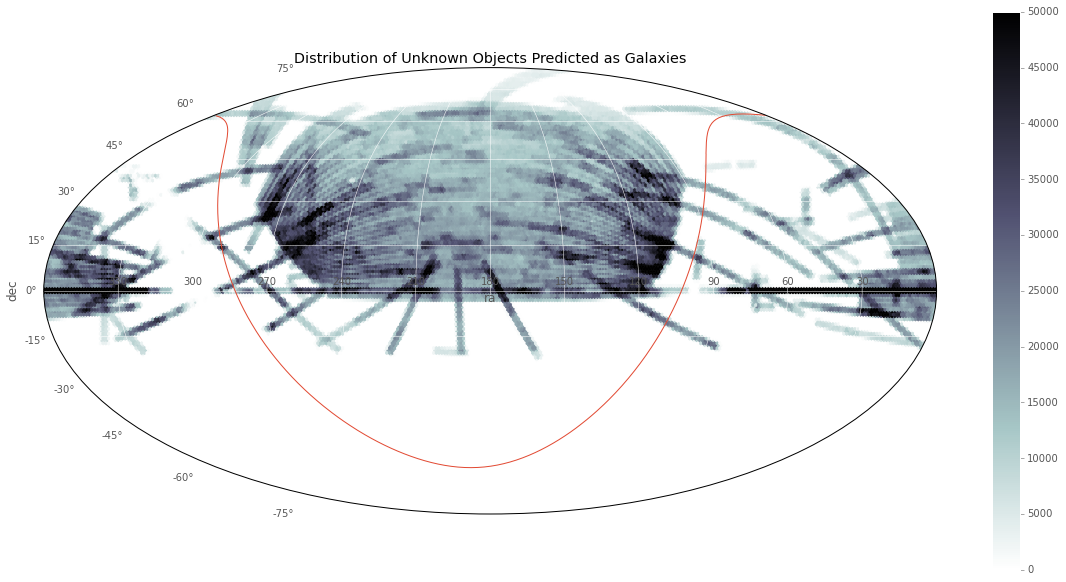

In [10]:
plot_hex_map(ras, decs, C=galaxies_map.flatten(), reduce_C_function=np.sum, gridsize=360,
             vmin=0, vmax=50000,
             origin=180, milky_way=True, title='Distribution of Unknown Objects Predicted as Galaxies')

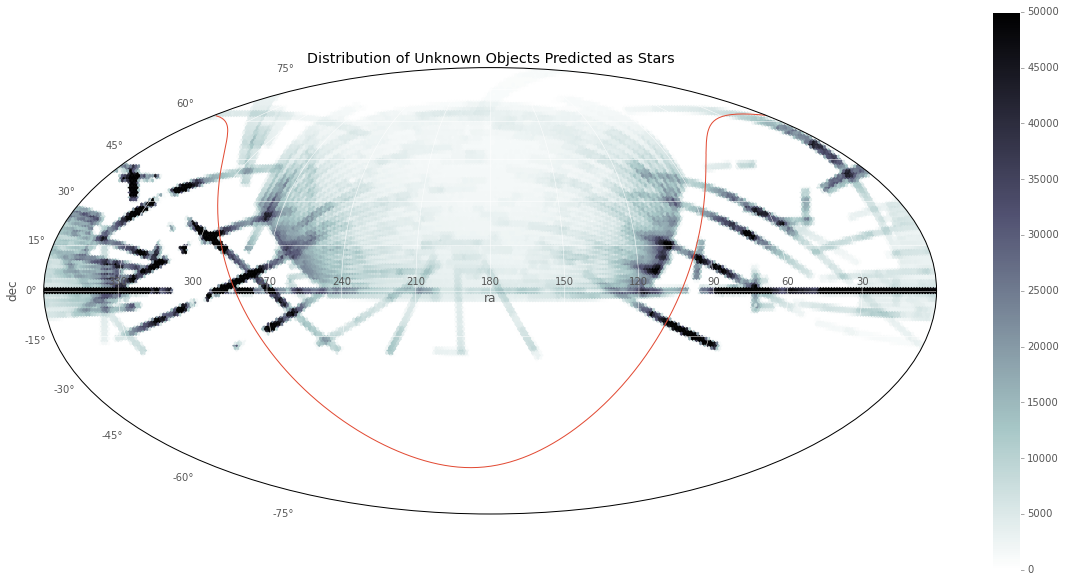

In [11]:
plot_hex_map(ras, decs, C=stars_map.flatten(), reduce_C_function=np.sum, gridsize=360,
             vmin=0, vmax=50000,
             origin=180, milky_way=True, title='Distribution of Unknown Objects Predicted as Stars')

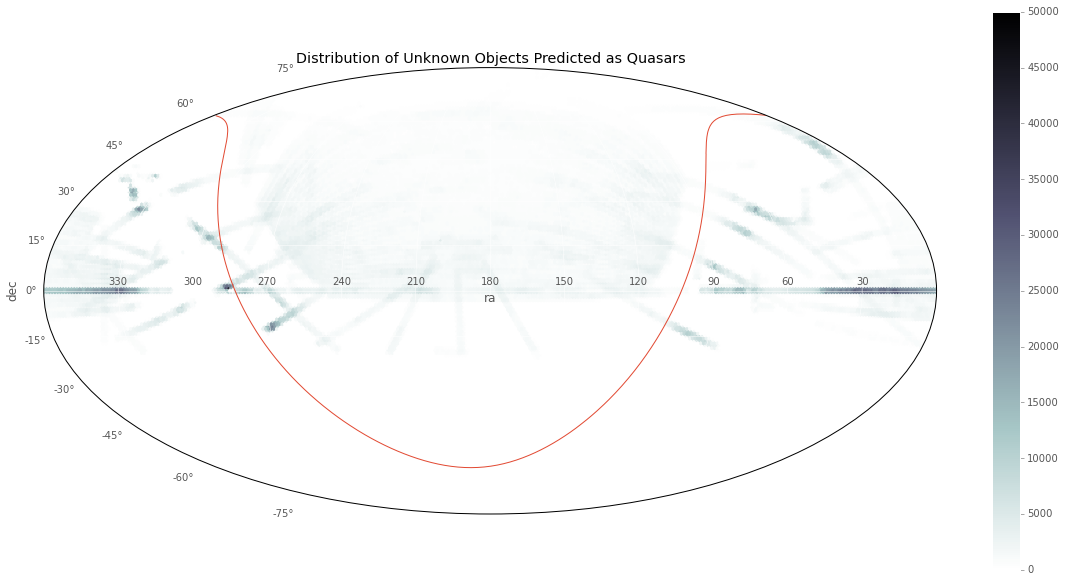

In [12]:
plot_hex_map(ras, decs, C=quasars_map.flatten(), reduce_C_function=np.sum, gridsize=360,
             vmin=0, vmax=50000,
             origin=180, milky_way=True, title='Distribution of Unknown Objects Predicted as Quasars')

## 4. Class Proportion

First we construct the normalised confusion matrix.

In [48]:
# order: galaxy, quasar star
confusion_matrix = np.array([
    [84339, 665, 331],
    [922, 16454, 1602],
    [707, 1978, 33053],
])

class_total = confusion_matrix.sum(axis=1)
class_total = np.tile(class_total, (3, 1)).transpose()
normalised_confusion = confusion_matrix / class_total
normalised_confusion

# put normalised confusion matrix in a DataFrame
classes = ['Galaxies', 'Quasars', 'Stars']
pred_index = MultiIndex.from_tuples(list(zip(['Predicted'] * 3, classes)))
act_index = MultiIndex.from_tuples(list(zip(['Actual'] * 3, classes)))
confusion_features_df = DataFrame(normalised_confusion, columns=pred_index, index=act_index)

# display results
print('Here\'s the normalised confusion matrix:')
confusion_features_df.applymap(lambda x: '{:.1%}'.format(x))

Here's the normalised confusion matrix:


Predicted               
                 Galaxies Quasars  Stars
Actual Galaxies     98.8%    0.8%   0.4%
       Quasars       4.9%   86.7%   8.4%
       Stars         2.0%    5.5%  92.5%

Here's the prediction of the random forest on the whole dataset.

In [52]:
total_galaxies = np.sum(galaxies_map)
total_quasars = np.sum(quasars_map)
total_stars = np.sum(quasars_map)
total = total_galaxies + total_quasars + total_stars

print('Number of predicted as galaxies: {:,} ({:.1%})'.format(total_galaxies, total_galaxies/total))
print('Number of predicted as quasars: {:,} ({:.1%})'.format(total_quasars, total_quasars/total))
print('Number of predicted as stars: {:,} ({:.1%})'.format(total_stars, total_stars/total))

Number of predicted as galaxies: 512,368,716 (87.4%)
Number of predicted as quasars: 37,023,990 (6.3%)
Number of predicted as stars: 37,023,990 (6.3%)


Let us now correct for the potential misclassfication.

In [63]:
corrected_galaxies = int(normalised_confusion[0][0] * total_galaxies + \
                         normalised_confusion[0][1] * total_quasars + \
                         normalised_confusion[0][2] * total_stars)

corrected_quasars = int(normalised_confusion[1][0] * total_galaxies + \
                        normalised_confusion[1][1] * total_quasars + \
                        normalised_confusion[1][2] * total_stars)

corrected_stars = int(normalised_confusion[2][0] * total_galaxies + \
                      normalised_confusion[2][1] * total_quasars + \
                      normalised_confusion[2][2] * total_stars)

print('Adjusted number of predicted as galaxies: {:,} ({:.1%})'.format(corrected_galaxies, corrected_galaxies/total))
print('Adjusted number of predicted as quasars: {:,} ({:.1%})'.format(corrected_quasars, corrected_quasars/total))
print('Adjusted number of predicted as stars: {:,} ({:.1%})'.format(corrected_stars, corrected_stars/total))

Adjusted number of predicted as galaxies: 506,820,660 (86.4%)
Adjusted number of predicted as quasars: 60,117,458 (10.3%)
Adjusted number of predicted as stars: 46,427,670 (7.9%)


## Recall the class proportions in the training data

In [3]:
counts = sdss['class'].value_counts()
print('Percentage of classes in training set')
print(counts/len(sdss))
print(counts)

Percentage of classes in training set
Galaxy    0.609508
Star      0.255021
Quasar    0.135472
dtype: float64
Galaxy    1707233
Star       714313
Quasar     379456
dtype: int64
